In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMG_PATH = './detection/Images/'
ANNO_PATH = './detection/Annotation/'

len(os.listdir(IMG_PATH))

14710

In [3]:
img = './detection/Images/T10_d01_002_a_1.jpg'

# plt.imshow(img)
# plt.plot()

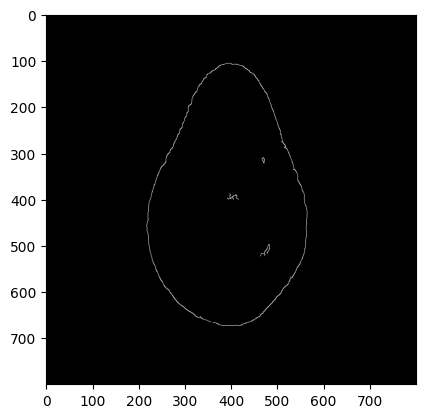

In [4]:
im = cv.imread(img)
# im = cv.imread("split-data/train/Ripe (First Stage)/T10_d04_227_a_3.jpg")
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (5, 5), 0)

# Edge detection
edges = cv.Canny(blurred, 100, 300)

plt.imshow(edges, cmap='gray')


In [5]:
import cv2 as cv

def avocado_detect(img):
    im = cv.imread(img)
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv.Canny(blurred, 100, 300)

    # Contours
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    img_h, img_w = im.shape[:2]

    txt_lines = []
    valid_contours = []

    # Collect valid contours based on area
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > 100:
            valid_contours.append(cnt)

    if valid_contours:
        # Find the overall bounding rectangle for all valid contours
        x_min = float('inf')
        y_min = float('inf')
        x_max = float('-inf')
        y_max = float('-inf')

        for cnt in valid_contours:
            x, y, w, h = cv.boundingRect(cnt)
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)

        # Calculate center and normalized dimensions
        cx = (x_min + (x_max - x_min) / 2) / img_w
        cy = (y_min + (y_max - y_min) / 2) / img_h
        nw = (x_max - x_min) / img_w
        nh = (y_max - y_min) / img_h
        txt_lines.append(f"0 {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")

        # Draw the single bounding rectangle
        im_vis = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        cv.rectangle(im_vis, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    else:
        im_vis = cv.cvtColor(im, cv.COLOR_BGR2RGB)

    return im_vis

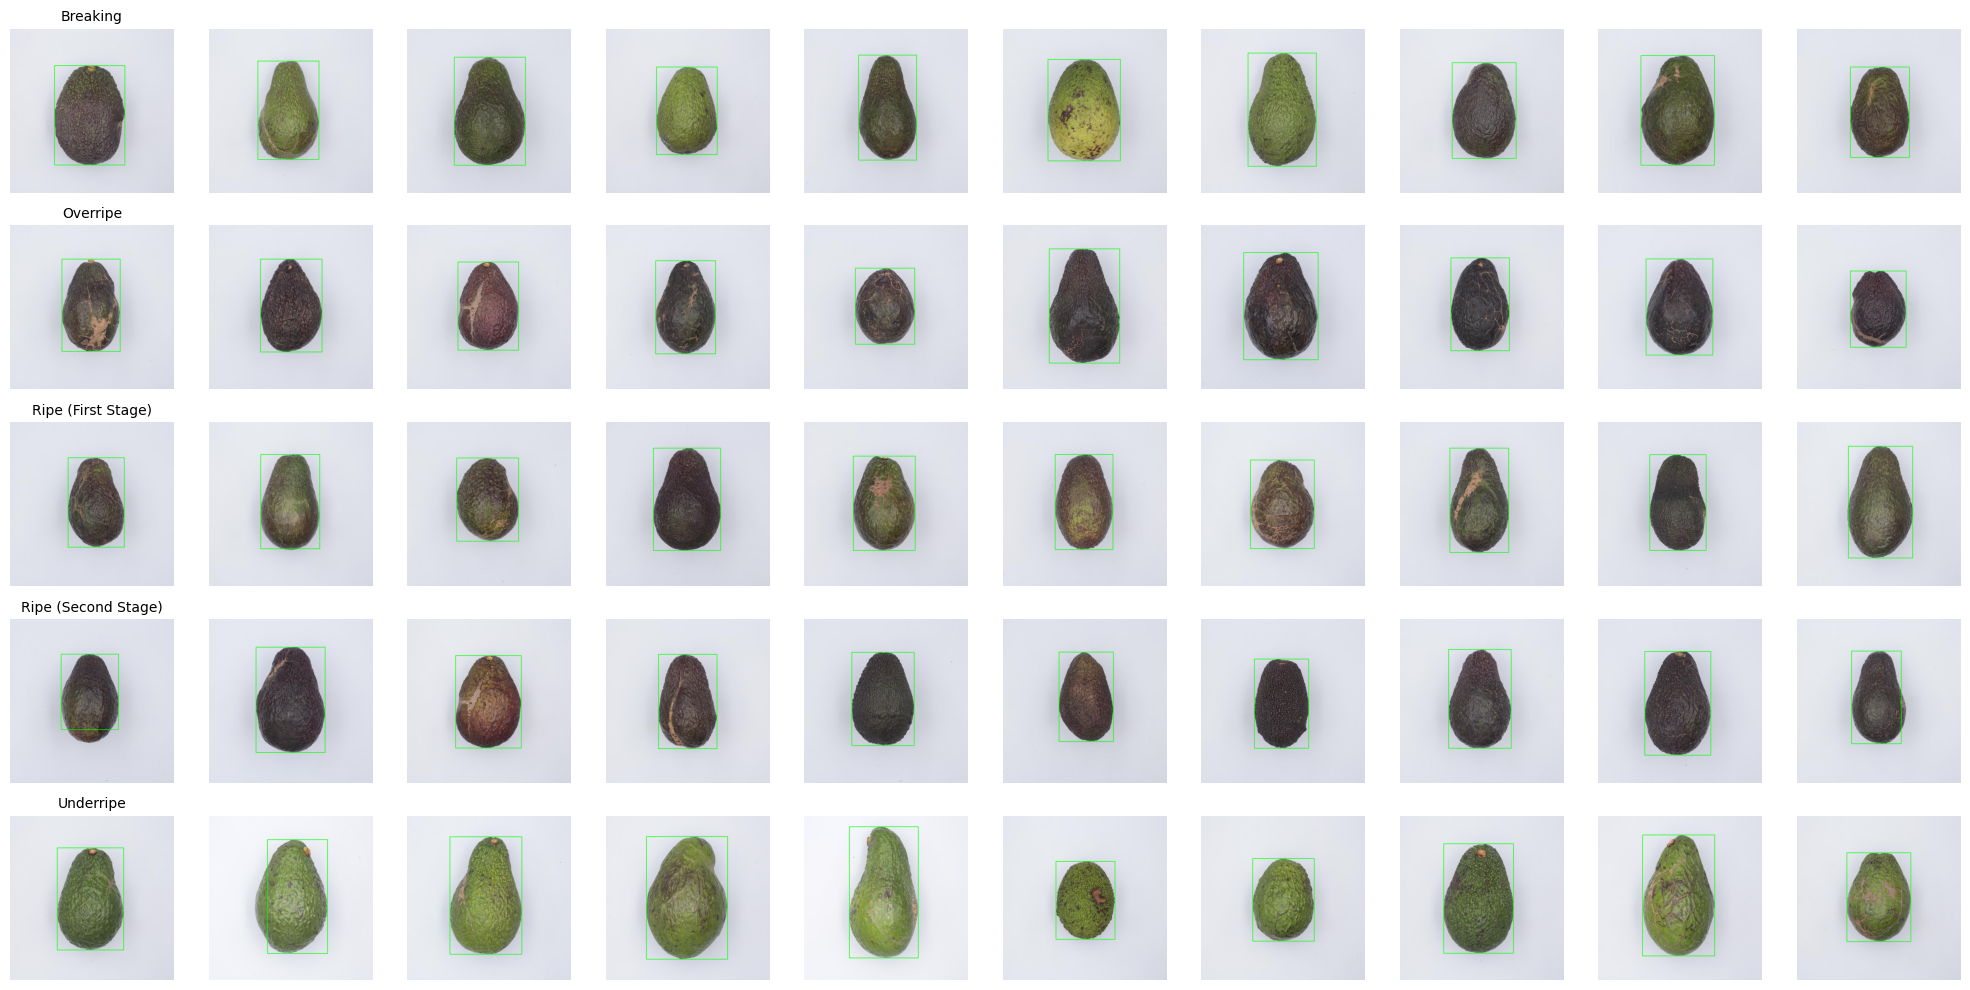

In [7]:
NEW_PATH = './split-data/train/'

# Get list of folders
folders = [f for f in sorted(os.listdir(NEW_PATH)) if os.path.isdir(os.path.join(NEW_PATH, f))]
num_folders = len(folders)

# Create a figure with one row per folder, and up to 10 columns for images
fig, axs = plt.subplots(num_folders, 10, figsize=(20, 2 * num_folders))

# Handle case where there's only one folder
if num_folders == 1:
    axs = np.array([axs]).reshape(1, -1)

# Loop through each folder
for idx, folder in enumerate(folders):
    folder_path = os.path.join(NEW_PATH, folder)
    # Get list of images in the folder
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    # Limit to 10 images
    images = images[:10]
    
    # Loop through up to 10 images
    for img_idx in range(10):
        if img_idx < len(images):
            img_path = os.path.join(folder_path, images[img_idx])
            img = avocado_detect(img_path)  # Assuming avocado_detect returns an image array
            axs[idx, img_idx].imshow(img)
            axs[idx, img_idx].axis('off')
            if img_idx == 0:
                axs[idx, img_idx].set_title(folder, fontsize=10)
        else:
            # Hide empty subplots
            axs[idx, img_idx].axis('off')

plt.tight_layout()
plt.show()

In [12]:
## Annotate the data
import os
import cv2 as cv
from xml.etree.ElementTree import Element, SubElement, tostring
from xml.dom import minidom

def avocado_annotate(img):
    # Read image
    im = cv.imread(img)
    if im is None:
        raise ValueError(f"Could not read image: {img}")
    
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv.Canny(blurred, 100, 300)

    # Contours
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    img_h, img_w = im.shape[:2]

    valid_contours = []

    # Collect valid contours based on area
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > 100:
            valid_contours.append(cnt)

    # Prepare Pascal VOC annotation
    annotation_dir = 'detection/Annotation'
    os.makedirs(annotation_dir, exist_ok=True)
    
    # Get image filename without path and extension
    img_filename = os.path.basename(img)
    img_name, _ = os.path.splitext(img_filename)
    xml_path = os.path.join(annotation_dir, f"{img_name}.xml")

    # Create XML structure
    annotation = Element('annotation')
    SubElement(annotation, 'folder').text = os.path.dirname(img)
    SubElement(annotation, 'filename').text = img_filename
    SubElement(annotation, 'path').text = img

    source = SubElement(annotation, 'source')
    SubElement(source, 'database').text = 'Unknown'

    size = SubElement(annotation, 'size')
    SubElement(size, 'width').text = str(img_w)
    SubElement(size, 'height').text = str(img_h)
    SubElement(size, 'depth').text = '3'

    SubElement(annotation, 'segmented').text = '0'

    if valid_contours:
        # Find the overall bounding rectangle for all valid contours
        x_min = float('inf')
        y_min = float('inf')
        x_max = float('-inf')
        y_max = float('-inf')

        for cnt in valid_contours:
            x, y, w, h = cv.boundingRect(cnt)
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)

        # Create object in XML
        obj = SubElement(annotation, 'object')
        SubElement(obj, 'name').text = 'avocado'
        SubElement(obj, 'pose').text = 'Unspecified'
        SubElement(obj, 'truncated').text = '0'
        SubElement(obj, 'difficult').text = '0'
        bndbox = SubElement(obj, 'bndbox')
        SubElement(bndbox, 'xmin').text = str(int(x_min))
        SubElement(bndbox, 'ymin').text = str(int(y_min))
        SubElement(bndbox, 'xmax').text = str(int(x_max))
        SubElement(bndbox, 'ymax').text = str(int(y_max))

        # Draw the single bounding rectangle
        im_vis = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        cv.rectangle(im_vis, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    else:
        im_vis = cv.cvtColor(im, cv.COLOR_BGR2RGB)

    # Save XML file
    rough_string = tostring(annotation, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    pretty_xml = reparsed.toprettyxml(indent="  ")
    
    with open(xml_path, 'w', encoding='utf-8') as f:
        f.write(pretty_xml)

    return im_vis

In [ ]:
# only run once

# for i in os.listdir('./detection/Images/'):
#     avocado_annotate(os.path.join('./detection/Images/', i))

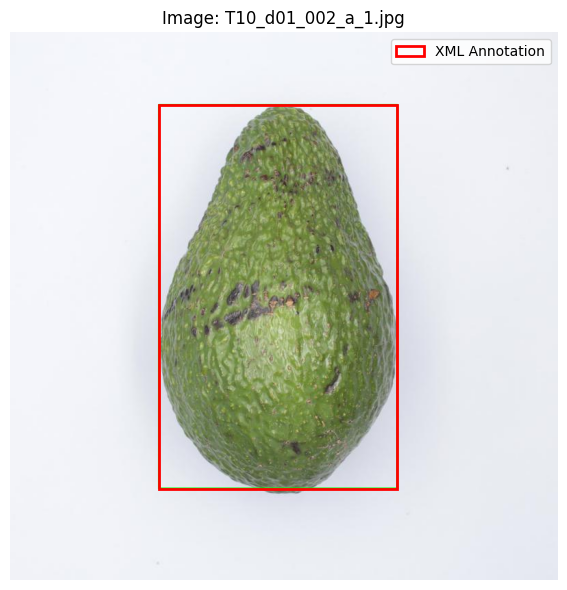

In [16]:
from xml.etree.ElementTree import parse
import matplotlib.patches as patches

img_path = './detection/Images/T10_d01_002_a_1.jpg'

# Process image to generate annotation and get visualization
img_vis = avocado_detect(img_path)

# Read XML annotation
img_name, _ = os.path.splitext(os.path.basename(img_path))
xml_path = os.path.join('detection/Annotation', f"{img_name}.xml")
if not os.path.exists(xml_path):
    raise ValueError(f"XML annotation not found at: {xml_path}")

tree = parse(xml_path)
root = tree.getroot()
bbox = None
for obj in root.findall('object'):
    bndbox = obj.find('bndbox')
    bbox = {
        'xmin': int(bndbox.find('xmin').text),
        'ymin': int(bndbox.find('ymin').text),
        'xmax': int(bndbox.find('xmax').text),
        'ymax': int(bndbox.find('ymax').text)
    }
    break  # Use first object (assuming one avocado per image)

# Plot image with bounding box from XML
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_vis)
if bbox:
    rect = patches.Rectangle(
        (bbox['xmin'], bbox['ymin']),
        bbox['xmax'] - bbox['xmin'],
        bbox['ymax'] - bbox['ymin'],
        linewidth=2, edgecolor='r', facecolor='none', label='XML Annotation'
    )
    ax.add_patch(rect)
    ax.legend()

ax.set_title(f"Image: {os.path.basename(img_path)}")
ax.axis('off')
plt.tight_layout()
plt.show()

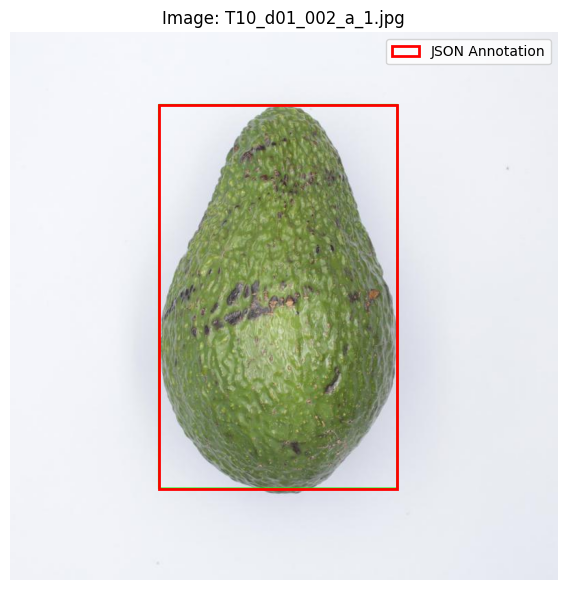

In [18]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import numpy as np

def avocado_detect(img, annotations_list):
    # Read image
    im = cv.imread(img)
    if im is None:
        raise ValueError(f"Could not read image: {img}")
    
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    edges = cv.Canny(blurred, 100, 300)
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    img_h, img_w = im.shape[:2]

    valid_contours = []
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > 100:
            valid_contours.append(cnt)

    # Prepare JSON annotation entry
    img_filename = os.path.basename(img)
    annotation_entry = {
        "imagefilename": img_filename,
        "annotation": []
    }

    if valid_contours:
        x_min = float('inf')
        y_min = float('inf')
        x_max = float('-inf')
        y_max = float('-inf')

        for cnt in valid_contours:
            x, y, w, h = cv.boundingRect(cnt)
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)

        # Calculate center and dimensions for JSON
        width = x_max - x_min
        height = y_max - y_min
        x_center = x_min + width / 2
        y_center = y_min + height / 2

        annotation_entry["annotation"].append({
            "coordinates": {
                "x": round(x_center, 3),
                "y": round(y_center, 3),
                "width": round(width, 3),
                "height": round(height, 3)
            },
            "label": "avocado"
        })

        im_vis = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        cv.rectangle(im_vis, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    else:
        im_vis = cv.cvtColor(im, cv.COLOR_BGR2RGB)

    annotations_list.append(annotation_entry)
    return im_vis, {"x_min": x_min, "y_min": y_min, "x_max": x_max, "y_max": y_max} if valid_contours else None

# Directory setup
NEW_PATH = './detection_createML/Images/'
annotation_dir = './detection_createML/'
os.makedirs(annotation_dir, exist_ok=True)
json_path = os.path.join(annotation_dir, 'annotations.json')

# Collect annotations for all images
annotations_list = []
first_image_data = None
first_image_vis = None

# Get all images in the single folder
images = [f for f in sorted(os.listdir(NEW_PATH)) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
if not images:
    raise ValueError(f"No images found in directory: {NEW_PATH}")

# Process all images but store first image for plotting
for img in images:
    img_path = os.path.join(NEW_PATH, img)
    im_vis, bbox = avocado_detect(img_path, annotations_list)
    if first_image_data is None:
        first_image_data = {"img_path": img_path, "bbox": bbox}
        first_image_vis = im_vis

# Save annotations to JSON
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(annotations_list, f, indent=2)

# Plot first image with bounding box
if first_image_data:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(first_image_vis)
    if first_image_data["bbox"]:
        bbox = first_image_data["bbox"]
        rect = patches.Rectangle(
            (bbox["x_min"], bbox["y_min"]),
            bbox["x_max"] - bbox["x_min"],
            bbox["y_max"] - bbox["y_min"],
            linewidth=2, edgecolor='r', facecolor='none', label='JSON Annotation'
        )
        ax.add_patch(rect)
        ax.legend()

    ax.set_title(f"Image: {os.path.basename(first_image_data['img_path'])}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    raise ValueError("No images processed")